Visualising the location of all clusters in the dataset

'../data/finalised_cutouts/cluster_cutouts'

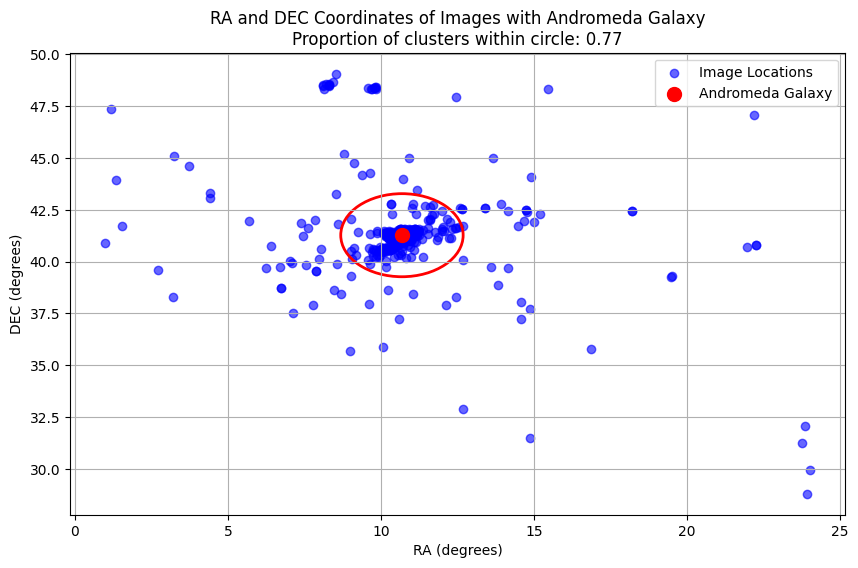

Total clusters: 473
Clusters within circle: 364
Proportion of clusters within circle: 0.77


In [26]:
import os
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Directory containing the images
image_directory = '../data/real_cutouts_cleaned/cluster'

# Lists to store RA and DEC values
ra_list = []
dec_list = []

# Function to extract RA and DEC from filename
def extract_ra_dec(filename):
    match = re.search(r'_(\d+\.\d+)_(\d+\.\d+)\.png$', filename)
    if match:
        ra = float(match.group(1))
        dec = float(match.group(2))
        return ra, dec
    return None, None

# Iterate over each file in the image directory
for root, dirs, files in os.walk(image_directory):
    for filename in files:
        if filename.lower().endswith('.png'):
            ra, dec = extract_ra_dec(filename)
            if ra is not None and dec is not None and 0 <= ra <= 50:
                ra_list.append(ra)
                dec_list.append(dec)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ra_list, dec_list, color='blue', alpha=0.6, label='Image Locations')

# Add a red dot for the Andromeda Galaxy
andromeda_ra = 10.6847083
andromeda_dec = 41.26875
plt.scatter(andromeda_ra, andromeda_dec, color='red', s=100, label='Andromeda Galaxy')

# Add a circle around the Andromeda Galaxy
circle_radius = 2  # Adjust the radius as needed
circle = Circle((andromeda_ra, andromeda_dec), radius=circle_radius, edgecolor='red', facecolor='none', linewidth=2)
plt.gca().add_patch(circle)

# Calculate the proportion of clusters within the circle
clusters_within_circle = 0
total_clusters = len(ra_list)

for ra, dec in zip(ra_list, dec_list):
    if ((ra - andromeda_ra)**2 + (dec - andromeda_dec)**2) <= circle_radius**2:
        clusters_within_circle += 1

proportion_within_circle = clusters_within_circle / total_clusters

# Add labels and title
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.title(f'RA and DEC Coordinates of Images with Andromeda Galaxy\nProportion of clusters within circle: {proportion_within_circle:.2f}')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

print(f"Total clusters: {total_clusters}")
print(f"Clusters within circle: {clusters_within_circle}")
print(f"Proportion of clusters within circle: {proportion_within_circle:.2f}")

In [28]:
import os
import re
import shutil
from matplotlib.patches import Circle

# Directory containing the images
image_directory = '../data/real_cutouts_cleaned/cluster'
within_circle_directory = '../data/real_cutouts_cleaned/within_circle'
outside_circle_directory = '../data/real_cutouts_cleaned/outside_circle'

# Create output directories if they don't exist
os.makedirs(within_circle_directory, exist_ok=True)
os.makedirs(outside_circle_directory, exist_ok=True)

# Andromeda Galaxy coordinates
andromeda_ra = 10.6847083
andromeda_dec = 41.26875
circle_radius = 2

# Function to extract RA and DEC from filename
def extract_ra_dec(filename):
    match = re.search(r'_(\d+\.\d+)_(\d+\.\d+)\.png$', filename)
    if match:
        ra = float(match.group(1))
        dec = float(match.group(2))
        return ra, dec
    return None, None

# Iterate over each file in the image directory
for root, dirs, files in os.walk(image_directory):
    for filename in files:
        if filename.lower().endswith('.png'):
            ra, dec = extract_ra_dec(filename)
            if ra is not None and dec is not None and 0 <= ra <= 50:
                # Check if the cluster is within the circle
                if ((ra - andromeda_ra)**2 + (dec - andromeda_dec)**2) <= circle_radius**2:
                    target_dir = within_circle_directory
                else:
                    target_dir = outside_circle_directory
                
                # Copy the image to the target directory
                shutil.copy(os.path.join(root, filename), os.path.join(target_dir, filename))

print("Clusters have been separated into the respective folders.")

Clusters have been separated into the respective folders.


Visualise the cummulative Yilun Wang objects, compared to their pgc

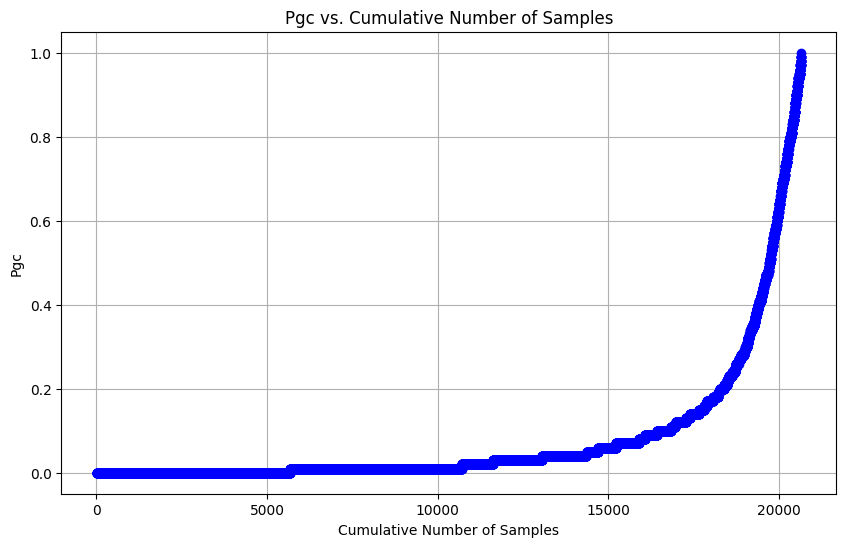

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
input_file = '../Finding Real Images/All_Yilun_Wang_data_for_Oscar.csv'
df = pd.read_csv(input_file)

# Sort the DataFrame by Pgc
df_sorted = df.sort_values(by='Pgc')

# Calculate the cumulative number of samples
df_sorted['Cumulative'] = range(1, len(df_sorted) + 1)

# Plot Pgc against the cumulative number of samples
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['Cumulative'], df_sorted['Pgc'], marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Cumulative Number of Samples')
plt.ylabel('Pgc')
plt.title('Pgc vs. Cumulative Number of Samples')
plt.grid(True)

# Show the plot
plt.show()